Hace falta algo que indique con qué entorno vamos a trabajar

Importar lo que hace falta

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

In [2]:
data_url = "../Data/properatti.csv"

In [3]:
data = pd.read_csv(data_url, encoding="utf-8")

In [4]:
#limpiamos los que tienen NaN en el precio
data = data.dropna(axis=0, how='any', subset=['price_aprox_usd'])

In [5]:
#funcion para borrar outliers.
def borrar_outliers(data, columnas):
    """Solo recibo columnas con valores numericos. 
    Las columns van en forma de tupla"""
    cols_limpiar = columnas
    mask=np.ones(shape=(data.shape[0]), dtype=bool)

    for i in cols_limpiar:
        
        #calculamos cuartiles, y valores de corte
        Q1=data[i].quantile(0.25)
        Q3=data[i].quantile(0.75)
        RSI=Q3-Q1
        max_value=Q3+1.5*RSI
        min_value=Q1-1.5*RSI
        
        #ajusto el min value a mano... no puede ser negativo.
        min_value=max(min_value, data[i].quantile(0.05))
        
        #filtramos por max y min
        mask=np.logical_and(mask, np.logical_and(data[i]>=min_value, data[i]<=max_value))
    return data[mask]

In [6]:
# por ahora sacamos los outliers de precio y metros cubiertos de todo el dataset, habría que hacerlo por zona y tipo

data = borrar_outliers(data, ('price_aprox_usd', 'surface_covered_in_m2'))

#### Categorizar precio

In [7]:
price_desc = data['price_aprox_usd'].describe()

In [8]:
price_desc

count     71285.000000
mean     178015.322455
std      105479.646428
min       53279.490000
25%       95237.990000
50%      145000.000000
75%      235000.000000
max      526957.000000
Name: price_aprox_usd, dtype: float64

In [9]:
price_bins = round( (price_desc['max'] - price_desc['min']) / 50000 ) 

In [10]:
data['price_cut'] = pd.cut(data['price_aprox_usd'], bins = price_bins, right = False, labels = None, retbins = False, precision = 0)

#### Categorizar superficie cubierta

In [11]:
surface_desc = data['surface_covered_in_m2'].describe()

In [12]:
surface_desc

count    71285.000000
mean        95.697889
std         64.493952
min         29.000000
25%         47.000000
50%         71.000000
75%        127.000000
max        307.000000
Name: surface_covered_in_m2, dtype: float64

In [13]:
surface_bins = round( (surface_desc['max'] - surface_desc['min']) / 50 ) 

In [14]:
data['surface_cut'] = pd.cut(data['surface_covered_in_m2'], bins = surface_bins, right = False, retbins = False, precision = 0)

## tabla de contingencia precio en dólares y superficie cubierta

In [15]:
pd.crosstab(index = data['price_cut'], columns = data['surface_cut'], margins = True, dropna = True, normalize = 'columns')

surface_cut,"[29.0, 75.0)","[75.0, 122.0)","[122.0, 168.0)","[168.0, 214.0)","[214.0, 261.0)","[261.0, 307.0)",All
price_cut,,,,,,,
"[53279.0, 105910.0)",0.487640,0.145705,0.071799,0.033408,0.014493,0.017484,0.302406
"[105910.0, 158541.0)",0.317237,0.262228,0.181272,0.088342,0.041017,0.038353,0.252325
"[158541.0, 211172.0)",0.119052,0.211383,0.234098,0.160840,0.098168,0.063170,0.150593
"[211172.0, 263803.0)",0.045334,0.160055,0.180317,0.184949,0.135630,0.106599,0.100063
"[263803.0, 316434.0)",0.013969,0.100034,0.127901,0.182711,0.154498,0.134236,0.067125
"[316434.0, 369064.0)",0.008293,0.057399,0.080945,0.163423,0.188953,0.172025,0.051722
"[369064.0, 421695.0)",0.004552,0.034012,0.057876,0.108145,0.166803,0.197406,0.037582
"[421695.0, 474326.0)",0.002302,0.016212,0.036582,0.047701,0.124419,0.143824,0.022136
"[474326.0, 527431.0)",0.001622,0.012970,0.029211,0.030480,0.076019,0.126904,0.016048


## Existe una importate asociación entre el precio en dólares y la superficie cubierta

---

In [16]:
def regex_to_tags(col, reg, match, not_match = np.NaN) :
    u"""Returns a series with 'match' values result of apply the regular expresion to the column
    the 'match' value will be when the regular expression search() method found a match
    the 'not_match' value will be when the regular expression serach() method did not found a match
    col : column where to apply regular expresion
    reg : regular expresion compiled
    """
    
    serie = col.apply(lambda x : x if x is np.NaN else reg.search(x))
    serie = serie.apply(lambda x : match if x is not None else not_match)
   
    return serie

In [17]:
_pattern = 'cochera|garage|auto'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data['cochera'] = regex_to_tags(data['description'], _express, 'si', 'no')


In [18]:
_pattern = 'piscina|pileta'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data['pileta'] = regex_to_tags(data['description'], _express, 'si', 'no')


In [19]:
_pattern = 'parrilla'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data['parrilla'] = regex_to_tags(data['description'], _express, 'si', 'no')


In [20]:
pd.crosstab(index = data['price_cut'], columns = data['cochera'], margins = True, dropna = True, normalize = 'columns')

cochera,no,si,All
price_cut,,,
"[53279.0, 105910.0)",0.371498,0.233106,0.302406
"[105910.0, 158541.0)",0.251653,0.253000,0.252325
"[158541.0, 211172.0)",0.133600,0.167636,0.150593
"[211172.0, 263803.0)",0.082754,0.117424,0.100063
"[263803.0, 316434.0)",0.052443,0.081851,0.067125
"[316434.0, 369064.0)",0.045495,0.057967,0.051722
"[369064.0, 421695.0)",0.031964,0.043216,0.037582
"[421695.0, 474326.0)",0.018041,0.026244,0.022136
"[474326.0, 527431.0)",0.012550,0.019557,0.016048


### Existe asociación entre el precio en dólares y la oferta de cochera solo en el rango de precios 53000 a 105000 

In [21]:
pd.crosstab(index = data['price_cut'], columns = data['pileta'], margins = True, dropna = True, normalize = 'columns')

pileta,no,si,All
price_cut,,,
"[53279.0, 105910.0)",0.354386,0.158084,0.302406
"[105910.0, 158541.0)",0.267588,0.209949,0.252325
"[158541.0, 211172.0)",0.147971,0.157872,0.150593
"[211172.0, 263803.0)",0.086989,0.136364,0.100063
"[263803.0, 316434.0)",0.055239,0.100127,0.067125
"[316434.0, 369064.0)",0.038352,0.088843,0.051722
"[369064.0, 421695.0)",0.025912,0.069983,0.037582
"[421695.0, 474326.0)",0.014062,0.044554,0.022136
"[474326.0, 527431.0)",0.009502,0.034223,0.016048


### Existe asociación entre el precio en dólares y la oferta de piltea solo en el rango de precios 53000 a 105000
#### En otros rangos se observa una diferencia de proporciones de hasta un 5% que podría considerarse

In [22]:
pd.crosstab(index = data['price_cut'], columns = data['parrilla'], margins = True, dropna = True, normalize = 'columns')

parrilla,no,si,All
price_cut,,,
"[53279.0, 105910.0)",0.370051,0.154855,0.302406
"[105910.0, 158541.0)",0.264562,0.225634,0.252325
"[158541.0, 211172.0)",0.141191,0.171100,0.150593
"[211172.0, 263803.0)",0.086257,0.130177,0.100063
"[263803.0, 316434.0)",0.049819,0.104873,0.067125
"[316434.0, 369064.0)",0.037359,0.083051,0.051722
"[369064.0, 421695.0)",0.025390,0.064174,0.037582
"[421695.0, 474326.0)",0.014547,0.038692,0.022136
"[474326.0, 527431.0)",0.010823,0.027446,0.016048


### Existe asociación entre el precio en dólares y la oferta de parrilla solo en el rango de precios 53000 a 105000
#### En otros rangos se observa una diferencia de proporciones de hasta un 5% que podría considerarse

In [23]:
data.dtypes


Unnamed: 0                       int64
operation                       object
property_type                   object
place_name                      object
place_with_parent_names         object
country_name                    object
state_name                      object
geonames_id                    float64
lat-lon                         object
lat                            float64
lon                            float64
price                          float64
currency                        object
price_aprox_local_currency     float64
price_aprox_usd                float64
surface_total_in_m2            float64
surface_covered_in_m2          float64
price_usd_per_m2               float64
price_per_m2                   float64
floor                          float64
rooms                          float64
expenses                       float64
properati_url                   object
description                     object
title                           object
image_thumbnail          

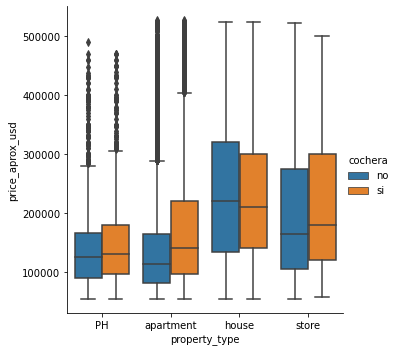

In [24]:
sns.catplot(x='property_type', y = 'price_aprox_usd', hue='cochera', data = data, kind='box')

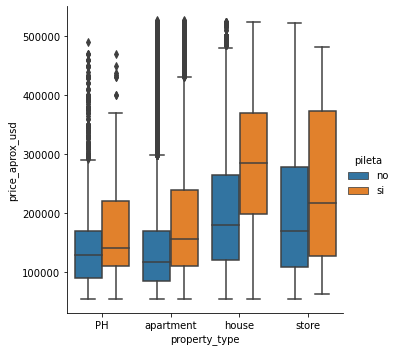

In [25]:
sns.catplot(x='property_type', y = 'price_aprox_usd', hue='pileta', data = data, kind='box')

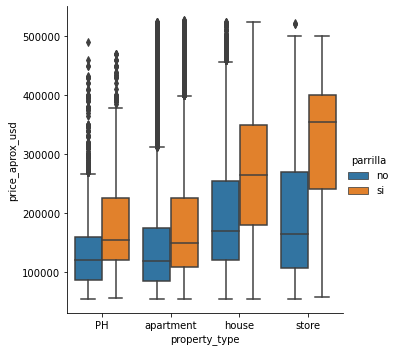

In [26]:
sns.catplot(x='property_type', y = 'price_aprox_usd', hue='parrilla', data = data, kind='box')

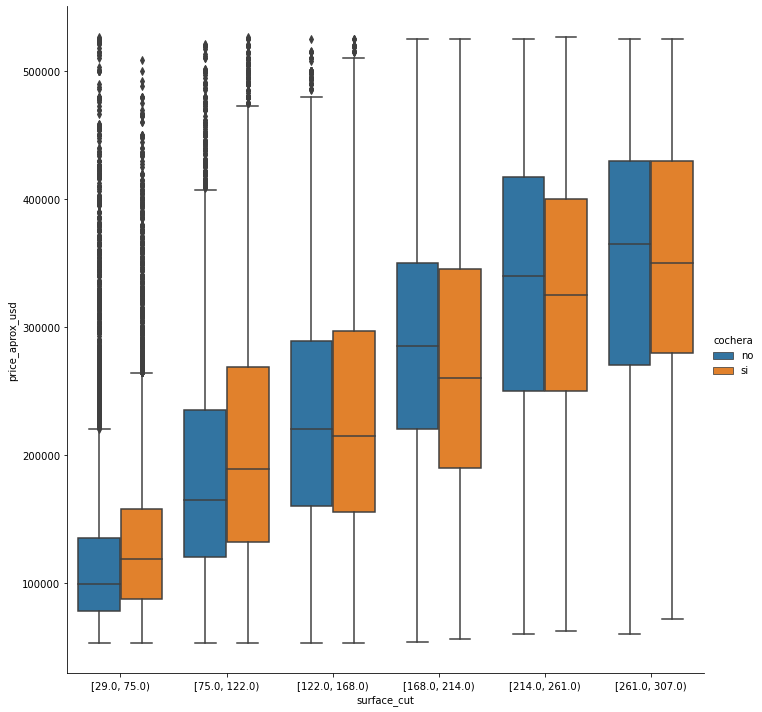

In [27]:
sns.catplot(x='surface_cut', y = 'price_aprox_usd', hue='cochera', data = data, kind='box', height = 10)

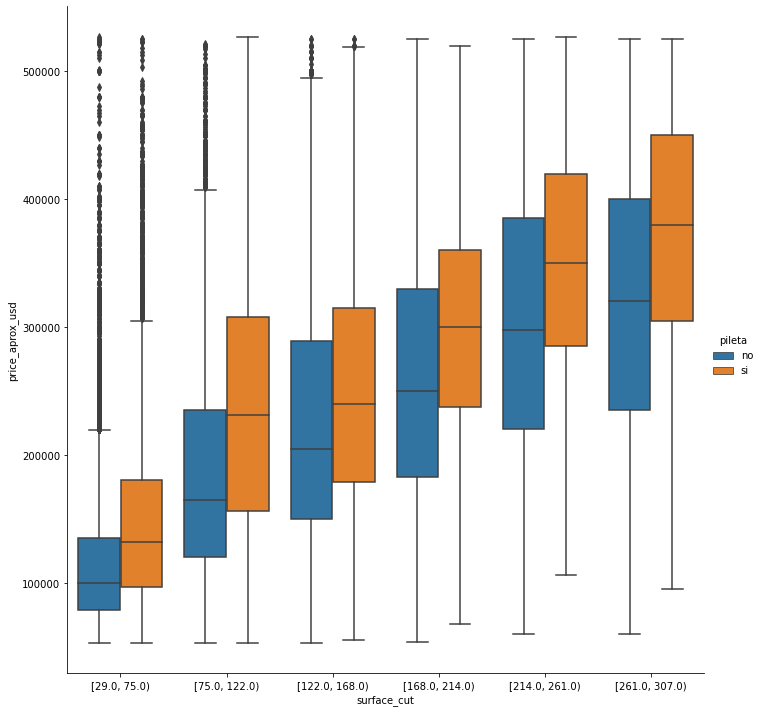

In [28]:
sns.catplot(x='surface_cut', y = 'price_aprox_usd', hue='pileta', data = data, kind='box', height = 10)

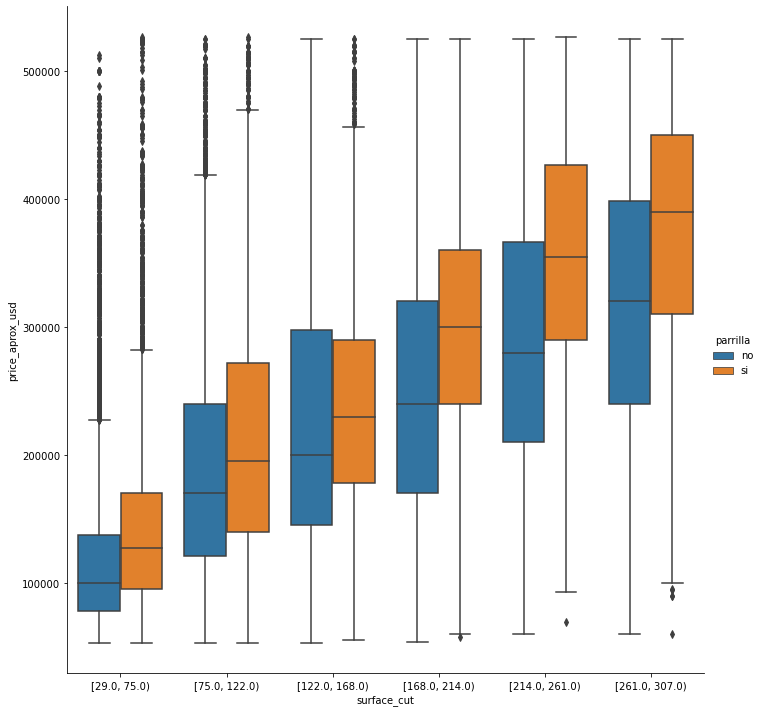

In [29]:
sns.catplot(x='surface_cut', y = 'price_aprox_usd', hue='parrilla', data = data, kind='box', height = 10)